# GP Regression w/ Noise

In this experiment, I want to investigate how does the noise affects the rbf derivative. I will include a plot of the signal to noise ratio as well as a mean sensitivity map for each of the functions.

#### Experimental Parameters

* Number of trials - x10 (random_state = off)
* Noise log scale from 0.001 to 0.5 with 20 values.
* Simple Functions x5 (linear, polynomial, sine, xsine, sinc)
* number of points = 500
* percentage of training = 0.6


#### Data

* Use the simple functions provided in the demo (linear, polynomial, sin, xsin, sinc)
* Store the derivatives for each of the trials and each of the functions
* Take the mean and standard deviation for all of the trials

#### Plots

* Plot the mean colormap derivative for each dataset
* Plot the signal to noise ratio with respect to the 

In [158]:
import sys
sys.path.insert(0,'/home/emmanuel/projects/2019_sakame/src')

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from data.make_dataset import ToyData
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
from models.gp_demo import DemoGP
from models.derivatives import RBFDerivative
from scipy.spatial.distance import pdist
import pandas as pd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Example

In [88]:
# Experiment parameters
num_points = 50
train_size = 0.6
random_state = 123
rng = check_random_state(random_state)
num_snr_values = 20
func = 'lin'
degree = 2

# SNR Values
snr_values = np.linspace(0, 50, num=num_snr_values)



#### Generate Signal

In [89]:
x = np.linspace(0, 3*np.pi, num_points)

def f(x, scaling=0.1):
    return np.sin(2 * np.pi * scaling * x)

def df(x, scaling=0.1):
    return (2 * np.pi * scaling) * np.cos(2 * np.pi * scaling * x)

signal = f(x)
signal = signal / signal.max()
std_signal = np.std(signal)

#### Generate Noise

In [90]:
std_noise = std_signal * (10**(-np.float(snr_values[0]) / 20))

print(f"SNR: {snr:.4f}")

noise = rng.normal(scale=std_noise, size=x.shape)

SNR: 66.4695


#### Generate Data

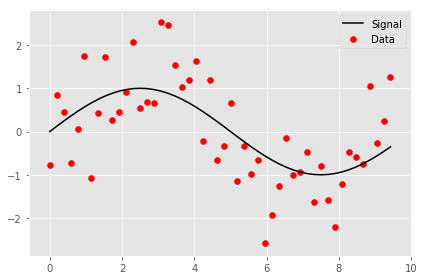

In [91]:
y = signal + noise

fig, ax = plt.subplots()
ax.plot(x, signal, color='k', label='Signal')
ax.scatter(x, y, color='r', label='Data')
ax.legend()
plt.tight_layout()
plt.show()

### Modeling the data (GPR)

In [189]:
%%time 

# Fix noise level
noise_variance = std_noise**2
print(f'Noise Variance: {noise_variance}')

# Fix length scale
length_scale = np.mean(pdist(x[:, None], metric='euclidean'))
print(f'Length Scale: {length_scale}')

demo_gpmodel = DemoGP(
    noise_variance=noise_variance,
    length_scale=length_scale
)
demo_gpmodel.train(x[:, None], y[:, None])

Noise Variance: 0.5184350120831609
Length Scale: 3.2698209251648866
CPU times: user 5.6 ms, sys: 2.06 ms, total: 7.66 ms
Wall time: 6.36 ms


In [190]:
demo_gpmodel.model.kernel_

RBF(length_scale=3.27) + WhiteKernel(noise_level=0.518)

In [191]:
ypred, y_std =demo_gpmodel.get_predictions(x[:, None], return_std=True)

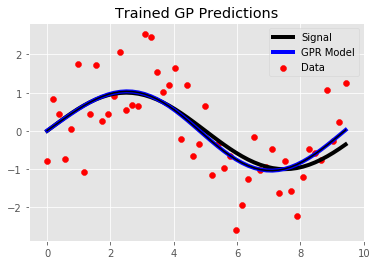

In [192]:
fig, ax = plt.subplots()

# Plot the Signal
ax.plot(x, x_signal, color='k', Linewidth=4, label='Signal')
# Plot the Data
ax.scatter(x, y, color='r', label='Data')
# Plot the GPR Model
ax.plot(x, ypred, color='b', Linewidth=4, label='GPR Model')

ax.plot(x, ypred, color='Black')
ax.set_title('Trained GP Predictions')
ax.legend()
plt.show()

### Useful Functions

In [193]:
def df_numerical(X, Y, n_derivative=1):
    """Simple Numerical derivative
    
    * 1st Derivatve: Forward Finite Difference Model, 
                     Backward Endpoint
    * 2nd Derivative: Centered Finite Different Model, 
                      Forward and Backward endpoints
    
    
    Parameters
    ----------
    X : array (n_samples)
    
    Y : array (n_samples)
    
    n_derivative : int, default=1
    
    Returns
    -------
    dF : (n_samples)
    
    """
    dF = np.zeros(X.shape[0])
    if int(n_derivative) == 1:
        dF[0:-1] = (Y[1:] - Y[0:-1]) / np.diff(X.squeeze())
        dF[-1] = (Y[-1] - Y[-2]) / (X[-1] - X[-2])
    elif int(n_derivative) == 2:
        dF[1:-1] = (Y[2:] - 2*Y[1:-1] + Y[0:-2]) / np.diff(X[:-1].squeeze())**2 
        dF[0] = (Y[1] - Y[0]) / (X[1] - X[0])
        dF[-1] = (Y[-1] - Y[-2]) / (X[-1] - X[-2])
    else:
        raise ValueError(f'Unrecognized n_derivative: {n_derivative}')
    
    
    return dF

In [194]:
df_num = df_numerical(x, ypred.squeeze())
df2_num = df_numerical(x, ypred.squeeze(), n_derivative=2)

df_gp = demo_gpmodel.get_derivatives(x[:, None])
df2_gp = demo_gpmodel.get_derivatives(x[:, None], n_derivative=2)

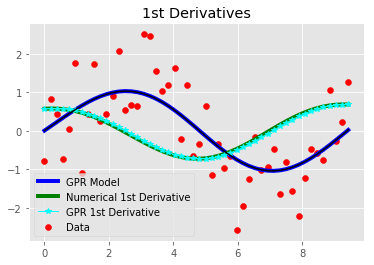

In [195]:
fig, ax = plt.subplots()

# Plot the Signal
# ax.plot(x, x_signal, color='k', Linewidth=4, label='Signal')
# Plot the Data
ax.scatter(x, y, color='r', label='Data')
# Plot the GPR Model
ax.plot(x, ypred, color='b', Linewidth=4, label='GPR Model')

# Plot Numerical Derivative
ax.plot(x, df_num, color='g', Linewidth=4, label='Numerical 1st Derivative')

# Plot GPR Derivative
ax.plot(x, df_gp, color='cyan', marker='*', Linewidth=1, label='GPR 1st Derivative')

ax.plot(x, ypred, color='Black')
ax.set_title('1st Derivatives')
ax.legend()
plt.show()

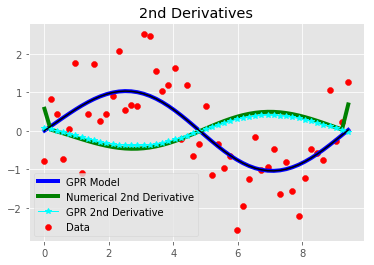

In [196]:
fig, ax = plt.subplots()

# Plot the Signal
# ax.plot(x, x_signal, color='k', Linewidth=4, label='Signal')
# Plot the Data
ax.scatter(x, y, color='r', label='Data')
# Plot the GPR Model
ax.plot(x, ypred, color='b', Linewidth=4, label='GPR Model')

# Plot Numerical Derivative
ax.plot(x, df2_num, color='g', Linewidth=4, label='Numerical 2nd Derivative')

# Plot GPR Derivative
ax.plot(x, df2_gp, color='cyan', marker='*', Linewidth=1, label='GPR 2nd Derivative')

ax.plot(x, ypred, color='Black')
ax.set_title('2nd Derivatives')
ax.legend()
plt.show()

### Norms 

In [197]:
# Extract GP Parameters
weights = demo_gpmodel.model.alpha_
K = demo_gpmodel.model.kernel_(x[:, None])

# Norm of weights
norm_weights = weights.T @ K.T @ weights

# Norm of f
norm_f = weights.T @ K.T @ K @ weights

# Norm of 1st Derivative
norm_df = np.linalg.norm(df_gp, ord=None)

# Norm of 1st Derivative
norm_df2 = np.linalg.norm(df2_gp, ord=None)

In [198]:
print(f"||w||: {norm_weights[0][0]:.4f}")
print(f"||f||: {norm_f[0][0]:.4f}")
print(f"||df||: {norm_df:.4f}")
print(f"||df2||: {norm_df2:.4f}")

||w||: 75.6841
||f||: 71.5349
||df||: 3.4822
||df2||: 1.8778


## Experiment

In [199]:
for inoise in noise_coefs:
    
    y = ToyData().regress_f(
        x,
        func=func,
        degree=degree,
        random_state=random_state
    )
    
    x, y = x[:, None], y[:, None]
    
    # split training and testing
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, train_size=train_size, random_state=random_state)
    
    # Train GP Model
    demo_gpmodel = DemoGP()
    demo_gpmodel.train(xtrain, ytrain)
    
    # Get Sensitivity
    break

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
